# AutoTrader (Q-Learning Trader)

This project aims to create a Q-Learning that learns how to trade cryptocurrencies by analysising historical data and finding the patterns of which indicates whether the agent should `BUY`, `SELL` or `NADA` when choosing its actions.

### Data Source

The data source for this experiment will be from the US-based cryptocurrency exchange [Poloniex](http://poloniex.com/). Where there are dozens of digital assets readily available for trading.

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:21: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


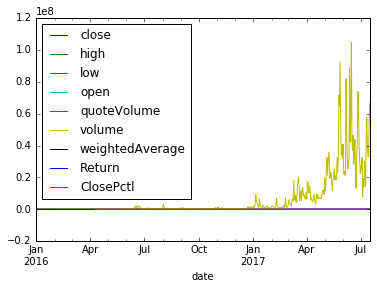

In [11]:
# Load poloniex API Wrapper
from poloniex import Poloniex
from datetime import datetime, date
import time
import pandas as pd
#from market_env import DataSource

from IPython.display import display # Allows the use of display() for DataFrames

# Previously set random_state, so that we can have reproducibility of results
random_state = 42

# Pretty display for notebooks
%matplotlib inline

# Build data into data frame
def build_dataframe(data):
  df = pd.DataFrame.from_dict(data)
  df['date'] = pd.to_datetime(df['date'], unit='s')
  df.set_index('date', inplace=True)
  df = df.convert_objects(convert_numeric=True)
  return df

def to_timestamp(dt):
  return (dt - datetime(1970, 1, 1)).total_seconds()


pol = Poloniex()
pair = 'USDT_BTC'

start_date = to_timestamp(datetime(2015, 12, 31))
#end_date = to_timestamp(datetime(2016, 12, 31))
end_date = time.time()

# Timestamp periods
SECOND = 1
MINUTE = 60 * SECOND
HOUR = MINUTE * 60
DAY = 24 * HOUR
WEEK = 7 * DAY

period = 300 # 5 minutes
data = pol.returnChartData(pair, DAY, start_date, end_date)
data = build_dataframe(data)
data['Return'] = data['close'].pct_change()

pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]
data['ClosePctl'] = data['close'].expanding(100).apply(pctrank)
data.plot()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:33: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:35: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()


,close,volume,daily_return,rolling_mean,close_mean_ration,close_pctl,volume_pctl
date,,,,,,,
2016-04-08,419.000100,5.414507e+04,-0.011792,422.245957,0.992313,0.650000,0.770000
2016-04-09,420.500000,5.584545e+04,0.003580,422.094098,0.996223,0.653465,0.772277
2016-04-10,419.719304,9.035382e+04,-0.001857,421.482713,0.995816,0.647059,0.941176
2016-04-11,422.752628,1.632047e+04,0.007227,421.804516,1.002248,0.699029,0.378641
2016-04-12,424.890000,6.984433e+04,0.005056,421.908802,1.007066,0.759615,0.865385
2016-04-13,425.000000,2.920716e+04,0.000259,422.266005,1.006475,0.761905,0.514286
2016-04-14,427.179969,3.522339e+04,0.005129,422.720286,1.010550,0.792453,0.575472
2016-04-15,430.617096,2.898400e+04,0.008046,424.379857,1.014697,0.841121,0.504673
2016-04-16,430.850000,2.008052e+04,0.000541,425.858428,1.011721,0.842593,0.416667


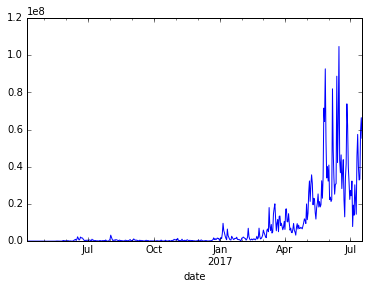

In [25]:
import gym
import pandas as pd
import numpy as np
import math
from poloniex import Poloniex

def sharpe_ratio(returns, freq=365) :
  """Given a set of returns, calculates naive (rfr=0) sharpe """
  return (np.sqrt(freq) * np.mean(returns))/np.std(returns)

def prices_to_returns(prices):
  px = pd.DataFrame(prices)
  nl = px.shift().fillna(0)
  R = ((px - nl)/nl).fillna(0).replace([np.inf, -np.inf], np.nan).dropna()
  R = np.append( R[0].values, 0)
  return R


class DataSource(object):
    '''
    Class responsible for querying data from Poloniex API, prepares it for the trading environment
    and then also acts as as data source for each step on the environment
    '''
    MinPercentileDays = 100 
    def __init__(self, pair, period, start_date, end_date, days = 365, client = Poloniex()):
        self.pair = pair
        self.days = days
        df = pd.DataFrame.from_dict(
          client.returnChartData(pair, period, start_date, end_date)
        )
        df['date'] = pd.to_datetime(df['date'], unit='s')
        df.set_index('date', inplace=True)
        df = df.convert_objects(convert_numeric=True)
        df['daily_return'] = df['close'].pct_change()
        rolling_mean = pd.stats.moments.rolling_mean(df['close'], 7)
        df['rolling_mean'] = rolling_mean
        df['close_mean_ration'] = df['close'] / rolling_mean
        pctrank = lambda x: pd.Series(x).rank(pct=True).iloc[-1]
        df['close_pctl'] = df['close'].expanding(self.MinPercentileDays).apply(pctrank)
        df['volume_pctl'] = df['volume'].expanding(self.MinPercentileDays).apply(pctrank)
        df.dropna(axis=0,inplace=True)

        self.data = df[['close', 'volume','daily_return','rolling_mean', 'close_mean_ration', 'close_pctl', 'volume_pctl']]

    def reset(self):
        self.idx = np.random.randint( low = 0, high=len(self.data.index)-self.days )
        self.step = 0

    def _step(self):
        '''
        Step function is responsible for geting the data for the current step and return it,
        it also returns whether we are done with the data as well
        '''
        obs = self.data.iloc[self.idx].as_matrix()
        self.idx += 1
        self.step += 1
        done = self.step >= self.days
        return obs, done

    def get_data(self):
        return self.data
      
class Simulator(object):
  
  def __init__(self, steps, trading_cost = 0, time_cost = 1e-4):
    self.steps = steps
    self.trading_cost = trading_cost
    self.time_cost = time_cost
    
    # Variables to be updated every step
    self.step = 0
    self.actions = np.zeros(self.steps)
    self.net_asset_values = np.ones(self.steps)
    

class MarketEnv(gym.Env):
    '''
    This GYM implements an environment in which an agent can simulate cryptocurrency trading
    '''
    def __init__(self):
        pass

    def reset(self):
        pass

    def _step(self):
        pass

# get the data from `returnChartData`
src = DataSource(pair, DAY, start_date, end_date)
display(src.get_data())


#src.get_data()['close'].plot()

#src.get_data()['daily_return'].plot()
src.get_data()['volume'].plot()
# src.data['volume_pctl'].plot()
# src.data['close_pctl'].plot()

### Visualize data

There are a few important public datapoints that are important for us in this context:

- We need to know the state of the price at that moment, given a pair. This can be accomplished by calling the `returnTicker` function passing in the trading pair (`BTC_ETH`) as an example.
- Also, it is important to have a feel for what is the state of current orders in the market, what does the current order book for this pair look like? What is the volume being traded?
- Thirdly, its important to have a feel for the price history of that given pair and how its been evolving. What is the daily return? What is the sharpe-ratio? Simple moving average?

### Environment

In order to be able to create a trading bot, we need to be able to simulate a trading environment, where the bot can visualize the current state of the market and take actions depending on it. For this to be done we need:

- An oracle (datasource) responsible for gathering data from the Exchanges client library;
- A Trading simulator that can run the trials of each step the agent needs when choosing an action, this simulator should
- A market environment where the reinforcement learning agent can act upon and measure its performance;
- A reward scheme, where the agent can get rewarded depending on its actions;
- Plot the price history over the trading period.
- Sharpe ratio (Always assume you have 252 trading days in an year. And risk free rate = 0) of the total portfolio
- Cumulative return of the total portfolio
- Standard deviation of daily returns of the total portfolio
- Average daily return of the total portfolio
- Ending value of the portfolio

#### Oracle

An oracle is a class responsible for gathering data from the market, it should:

- Get data fromt the market;
- Transform this data into desirable values. For example, daily return, bolinger value, simple moving average.
- Serve the new data everytime a step is updated;
- Reset the data frame accordingly when the step is over and the `reset()` method is called;

#### Simulator

A trading simulator responsible for simulating the act of trading on the exchange. It should:

- Keep track of the value currently invested in the coin;
- Keep track of the costs incurred with trading in the exchange;
- Compute the reward for user and return the information of this user gathered from the exchange and current state of the market.
- Compute the change in state executed on your own portfolio.
    - What happens when a `buy` order comes in?
        - We should reduce the amount of cash currently available on the account and increase the amount.
    - What happens when a `sell` order comes in?
       - Increase the amount of cash we have and reduce the amount of coins.

#### Exchange

This class is responsible for gathering information about the exchange and the cost incurred with each trade. Also, it should be responsible for keeping track of which positions we currently hold with the exchange. 

- `__init__(trader_id)`
- Build the cost table for the exchange. [See here](https://poloniex.com/fees/)
- `current_cost()` for the user
- `open_trades()`: get open trades method
- `get_balance()`: query this trader's balance

#### Portfolio 

This class is responsible for keeping track of the current trader's own portfolio. It should have:

- `get_portfolio_trades()`
- `buy()` - What happens when a `buy` order comes in? - We should deduce the amount of cash currently available on the account and increase the amount 
- `sell()` - What happens when a `sell` order comes in?

#### Define state space

In order to have a reinforcement learning agent, it is necessary to define the agents state space.

- Do we currently hold any coins or not (of whatever cryptocurrency we are currently trading), this is binary true or false (0 or 1).
- Bolinger value, how is the current state of prices going compared with the simple moving average. This value needs to be discretized, in order to be able to use it as a state. See OpenAI Gym's `Discretize` class. 
- Coin's daily return is also a good value as part of the state. This also needs to be discretized.
- Ration between the close price and the rolling mean (simple moving average)

When what we are trading is bitcoin:
- Number of transactions happening on the blockchain that date; See https://api.blockchain.info/charts/n-transactions?format=json&timespan=all
- Number of unique addresses generated. See: https://blockchain.info/charts/n-unique-addresses
- Number of unspent transaction output. Which basically means the number of unspent bitcoins being generated everyday cumulatively. See: https://blockchain.info/charts/utxo-count
- Estimated transaction value. See: https://blockchain.info/charts/estimated-transaction-volume-usd


#### Actions

- BUY (1)
- SELL (-1)
- NADA (0)

#### Agent

Agent timeline:
1. Aiming to simplify the task at hand, we shall create an agent that chooses the available actions randomly. `RandomAgent`
2. Create a Q-learning agent that trains on 2016 data and tests on 2017. `QAgent`
3. Improve Q-learning agent by introducing the concept of halucination, allowing the agent to halucinate on every single day many possible scenarios for the asset on that day. `QAgent`
